# Explore here

It's recommended to use this notebook for exploration purposes.

Actual columns found: ['Rank', 'Song', 'Artist', 'Streams(billions)', 'Release date', 'Ref.']
Data stored in SQLite successfully.


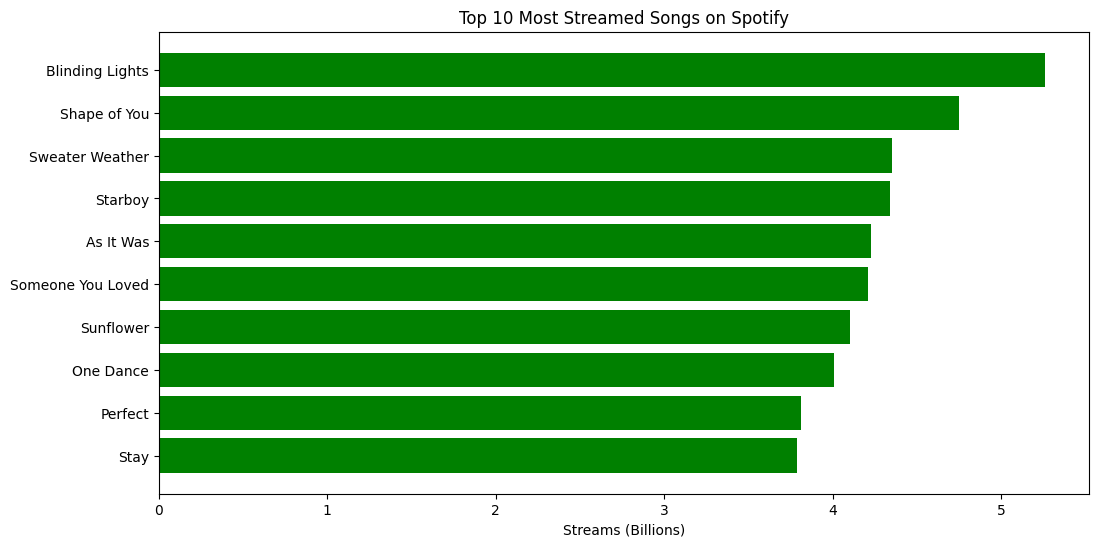

In [11]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

# --- STEP 1: Install dependencies ---
# This step is handled in your terminal via: pip install pandas requests lxml beautifulsoup4

# --- STEP 2: Download HTML ---
url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"
headers = {"User-Agent": "Mozilla/5.0"} # Prevents 403 error

response = requests.get(url, headers=headers)
html_content = response.text # Collect and store scraped text

# --- STEP 3: Transform the HTML ---
soup = BeautifulSoup(html_content, 'html.parser')
table = soup.find('table', {'class': 'wikitable'}) 

data = []
rows = table.find_all('tr')
for row in rows:
    # Look for both header (th) and data (td) cells
    cols = row.find_all(['td', 'th'])
    cols = [ele.text.strip() for ele in cols]
    data.append(cols)

# Create DataFrame
df = pd.DataFrame(data[1:], columns=data[0]) 

# --- STEP 4: Process the DataFrame ---
# FIX: Clean the column names immediately to remove things like "Artist(s)" or hidden refs
df.columns = [re.sub(r'\[.*?\]', '', str(col)).replace('(s)', '').strip() for col in df.columns]

# Print columns to verify 'Artist' and 'Song' exist now
print("Actual columns found:", df.columns.tolist())

# Now the cleaning should work without the KeyError
def clean_text(text):
    return re.sub(r'\[.*?\]', '', str(text)).replace('"', '').strip()

# We check if the column exists before applying to prevent crashes
if 'Song' in df.columns:
    df['Song'] = df['Song'].apply(clean_text)
if 'Artist' in df.columns:
    df['Artist'] = df['Artist'].apply(clean_text)

# Clean the Streams column (usually the 4th column, index 3)
# We use iloc to be safe if the header name is weird
df['Streams (billions)'] = df.iloc[:, 3].apply(lambda x: re.sub(r'[^\d.]', '', clean_text(x)))
df['Streams (billions)'] = pd.to_numeric(df['Streams (billions)'], errors='coerce')

df.dropna(subset=['Song', 'Artist'], inplace=True)

# --- STEP 5: Store the data in SQLite ---
conn = sqlite3.connect('spotify_data.db')
cursor = conn.cursor()

# 1. Create the table
# 2. Insert the values
# 3. Commit the changes
df.to_sql('most_streamed_songs', conn, if_exists='replace', index=False)
conn.commit()
print("Data stored in SQLite successfully.")

# --- STEP 6: Visualize the data ---
# Suggestion: Plot Top 10 songs by stream count
top_10 = df.sort_values(by='Streams (billions)', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.barh(top_10['Song'], top_10['Streams (billions)'], color='green')
plt.xlabel('Streams (Billions)')
plt.title('Top 10 Most Streamed Songs on Spotify')
plt.gca().invert_yaxis()
plt.show()

conn.close()
